In [1]:
import numpy
import pandas
import sys
import os
import seaborn
from scipy.io import mmread
from matplotlib import pyplot
from glob import glob
import dask
import dask.dataframe
import dask.bag
from dask.distributed import Client, LocalCluster

In [2]:
%matplotlib inline

In [3]:
#dask_cluster = dask.distributed.LocalCluster()
#dask_client = Client('[::1]:8786')

In [4]:
# I got the reader into pandas.
#PANDASODF = os.path.expanduser('~diane/src/pandasodf')
#if PANDASODF not in sys.path:
#    sys.path.append(PANDASODF)
#from pandasodf import ODFReader

In [5]:
LONG_RNA_SEQ_DIR = os.path.expanduser('~diane/proj/long-rna-seq-condor')
if LONG_RNA_SEQ_DIR not in sys.path:
    sys.path.append(LONG_RNA_SEQ_DIR)

In [6]:
from woldrnaseq.models import load_gtf_cache
from woldrnaseq.gtfcache import protein_coding_gene_ids

In [7]:
annotation = load_gtf_cache(os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5'))
#gtf_cache = os.path.expanduser('~diane/proj/genome/mm10-M4-male/mm10-M4-male.h5')
#annotation = dask.dataframe.read_hdf(gtf_cache, '/*')
protein_coding = protein_coding_gene_ids(annotation)

What does a 10x expression matrix look like?

Function to load and annotate a 10x expression array into a dataframe.

In [8]:
def load_10x_filtered_features(root):
    mmdir = os.path.join(root, 'outs', 'filtered_feature_bc_matrix')
    filename = os.path.join(mmdir, 'matrix.mtx.gz')
    sparse = mmread(filename)
    df = pandas.DataFrame(sparse.toarray())
    
    features = pandas.read_csv(
        os.path.join(mmdir, 'features.tsv.gz'),
        header=None,
        names=['gene_id'],
        usecols=[0],
        sep='\t')
    df.index=features['gene_id']
    
    barcodes = pandas.read_csv(
        os.path.join(mmdir, 'barcodes.tsv.gz'),
        header=None,
        names=['barcode'],
        sep='\t')
    df.columns = barcodes['barcode']

    return df
    
    

In [9]:
#wold10x_10 = load_10x_filtered_features('Wold10x-10-encode-count-cells10000')

If I reorder the row features of the matrix, does label based indexing still point to the same row?

In [10]:
#numpy.all(wold10x_10.loc[protein_coding].loc['ENSMUSG00000025903.10'] == wold10x_10.loc['ENSMUSG00000025903.10'])

In [11]:
#detected = wold10x_10[wold10x_10 > 1].count()
#detected[detected > 1000].shape

jobs = []
encode_dirs = glob(os.path.expanduser('~diane/proj/brian-2018-01-10x/Wold10x-*-encode-count-cells10000'))
for i, dirname in enumerate(encode_dirs):
    experiment_name = dirname.replace('-encode-count-cells10000', '')
    #print('Processing', experiment_name, i+1, '/', len(encode_dirs))
    experiment = dask.delayed(load_10x_filtered_features)(dirname)
    protein_only = experiment.loc[protein_coding]
    expressed = experiment[experiment >= 1].count()
    detected = expressed[expressed > 1000]
    #print('  ', expressed.shape[0], detected.shape[0], experiment.shape)
    jobs.append(detected)
detected_counts_futures = dask.bag.from_delayed(jobs)
    

# Load approved 10x cell list

In [12]:
barcodes = pandas.read_csv('monocle/mouse/barcodes-to-cluster.csv', header=0, index_col=0)
print(barcodes.shape)
barcodes.head()

(90637, 1)


,orig.ident
limb12_13_0AAACCTGAGATCGATA_1,3
limb12_13_0AAACCTGAGATGAGAG_1,2
limb12_13_0AAACCTGAGCAGATCG_1,5
limb12_13_0AAACCTGAGCGATCCC_1,6
limb12_13_0AAACCTGAGTGTACCT_1,1


In [13]:
barcode_filter_by_run = {}
for barcode in barcodes.index:
    run = barcode[4:barcode.find('_')]
    cell_barcode = barcode[barcode.find('_', 7)+2:].replace('_', '-')
    barcode_filter_by_run.setdefault(run, set()).add(cell_barcode)

Need to format barcodes to look like this format 'limb12_13_0AAACCTGAGATCGATA_1'

In [14]:
tenx_timepoints = {
    1: '13_5',
    3: '11_0',
    4: '12_0',
    5: '13_0',
    6: '15_0',
    7: '10_5',
    8: '15_0',
    12: '13_0',
    13: '14_0',
}

In [15]:
detected_counts = []
encode_dirs = glob(os.path.expanduser('~diane/proj/brian-2018-01-10x/Wold10x-*-encode-count-cells10000'))
for i, dirname in enumerate(encode_dirs):
    experiment_name = dirname.replace('-encode-count-cells10000', '')
    path, name = os.path.split(experiment_name)
    prefix, run = name.split('-')

    if run not in barcode_filter_by_run:
        print('Skipping', run, experiment_name)
    else:
        valid_barcodes = barcode_filter_by_run[run]
        print('Processing', prefix,  experiment_name, i+1, '/', len(encode_dirs))
        experiment = load_10x_filtered_features(dirname).loc[protein_coding]

        if valid_barcodes is not None:
            print(len(valid_barcodes), len(experiment.columns), len(valid_barcodes.intersection(experiment.columns)))
            experiment = experiment[valid_barcodes]

        expressed = experiment[experiment >= 1].count()
        #detected = expressed[expressed > 1000]
        detected = expressed
        print('  ', expressed.shape[0], detected.shape[0], experiment.shape)
        detected_counts.extend(detected.tolist())

Skipping 9 /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-9
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-5 2 / 12
9705 10031 9705
   9705 9705 (22032, 9705)
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-13 3 / 12
9225 10104 9225
   9225 9225 (22032, 9225)
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-1 4 / 12
8303 8697 8303
   8303 8303 (22032, 8303)
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-6 5 / 12
11958 15132 11958
   11958 11958 (22032, 11958)
Skipping 10 /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-10
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-12 7 / 12
11311 11609 11311
   11311 11311 (22032, 11311)
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wold10x-4 8 / 12
6503 6566 6503
   6503 6503 (22032, 6503)
Processing Wold10x /woldlab/loxcyc/home/diane/proj/brian-2018-01-10x/Wol

In [16]:
experiment.shape

(22032, 17574)

In [17]:
expressed_10x = pandas.Series(detected_counts).to_frame()
expressed_10x.columns = ['counts']
expressed_10x['experiment type'] = '10x'
print(expressed_10x.shape)
expressed_10x.head()

(90637, 2)


,counts,experiment type
0,3031,10x
1,1809,10x
2,2192,10x
3,3936,10x
4,2725,10x


In [18]:
genes_asof17 = pandas.read_csv(
    os.path.expanduser('~diane/proj/C1_mouse_limb_combined/C1_mouse_combined_asof_run17.tsv'),
    dtype={0: str},
    index_col=0,
    sep='\t')

In [19]:
# Directly using ODFReader
#book = ODFReader(os.path.expanduser('~diane/proj/C1_mouse_limb_combined/C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods'))
#clusters = book.parse('Sheet1')

clusters = pandas.read_excel(
    os.path.expanduser('~diane/proj/C1_mouse_limb_combined/C1_single_cells_library_number_cell_type_annotation_Jan13_2019.ods'),
    'Sheet1',
    engine='odf',
)
clusters = clusters[['cell_ID', 'cell type cluster 920']]

In [20]:
c1_matrix = genes_asof17.loc[protein_coding][clusters.cell_ID]
c1_matrix.shape

(22032, 920)

In [21]:
expressed_c1 = c1_matrix[c1_matrix >= 1].count()

In [22]:
expressed_c1.name = 'counts'
expressed_c1.index.name = 'cell_ID'
expressed_c1 = expressed_c1.to_frame().reset_index()
expressed_c1['experiment type'] = 'C1'
expressed_c1.head()

,cell_ID,counts,experiment type
0,18317_G10,7822,C1
1,20040_B1,6802,C1
2,20044_A10,7138,C1
3,20042_D4,6972,C1
4,18255_E8,7306,C1


In [23]:
combined = pandas.concat([expressed_10x, expressed_c1], sort=False)

In [24]:
def resize_label(ticks, fontsize):
    for label in ticks:
        label.set_fontsize(fontsize)
        yield label


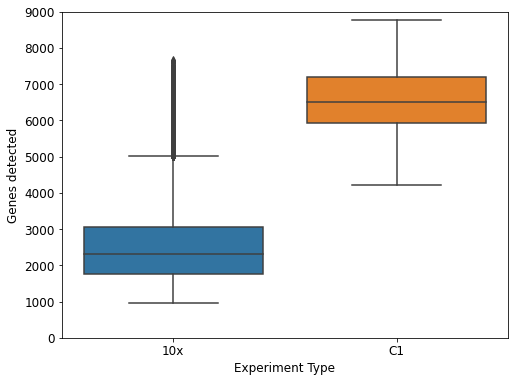

In [25]:
fontsize = 12.0
f = pyplot.figure(figsize=(8,6))
ax = f.add_subplot(1,1,1)
_ = seaborn.boxplot(x='experiment type', y='counts', data=combined, ax=ax)
_ = ax.set_ylim(0, 9000)
_ = ax.set_yticklabels(range(0, 9001, 1000), size=fontsize)
_ = ax.set_xticklabels(resize_label(ax.get_xticklabels(), fontsize))
_ = ax.set_xlabel('Experiment Type', size=fontsize)
#_ = ax.set_ylabel('Count of protein coding genes $\geq$ 1 FPKM per cell', size=fontsize)
_ = ax.set_ylabel('Genes detected', size=fontsize)



In [26]:
colors = {
    '10x': '#377eb8',
    'C1': '#f3b125',
}
fontsize = 24.0


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


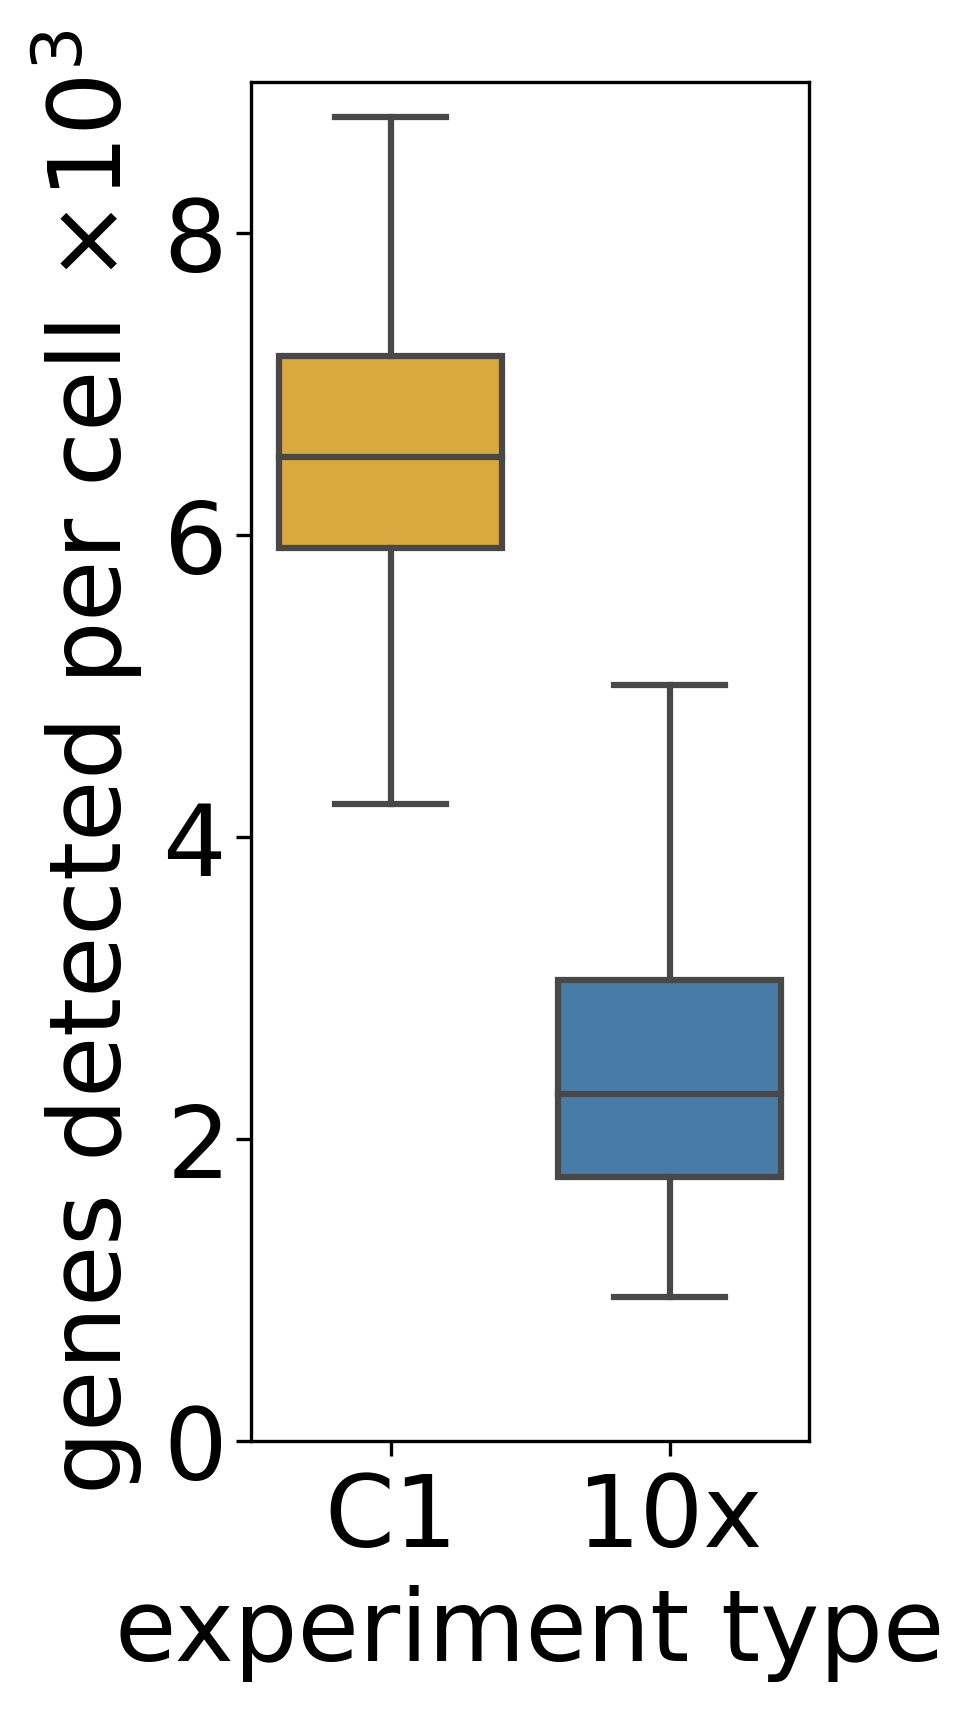

In [27]:
def compare_genes_detected(data, colors, fontsize, fontname='Arial', ax=None, dpi=300):
    #f = pyplot.figure(figsize=(0.6,6), dpi=300)
    if not ax:
        f = pyplot.figure(figsize=(2.4,6), dpi=dpi)
        ax = f.add_subplot(1,1,1)
    _ = seaborn.boxplot(x='experiment type', y='counts', data=data, 
                        order=['C1', '10x'],
                        palette=colors,
                        ax=ax, showfliers=False)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)
    _ = ax.set_ylim(0, 9000)
    #_ = ax.set_yticklabels(range(0, 9001, 1000), size=fontsize)
    for l in ax.get_yticklabels():
        l.set_fontsize(fontsize)
        l.set_fontname(fontname)
    _ = ax.set_yticks(range(0, 10000, 2000))
    #_ = ax.set_yticklabels(['0'] + [(str(x) + 'k') for x in range(2, 10, 2)], size=fontsize)
    _ = ax.set_xticklabels(resize_label(ax.get_xticklabels(), fontsize),fontname=fontname)
    _ = ax.set_xlabel('experiment type', fontsize=fontsize, fontname=fontname)
    #_ = ax.set_ylabel('Count of protein coding genes $\geq$ 1 FPKM per cell', size=fontsize)
    _ = ax.set_ylabel('genes detected per cell $\\times$10$^3$', fontsize=fontsize, fontname=fontname)
    ax.get_yaxis().get_offset_text().set_fontsize(fontsize-.2 * fontsize)
    ax.get_yaxis().get_offset_text().set_visible(False)
    
    return ax.figure

f = compare_genes_detected(combined, colors, fontsize)

In [28]:
f.savefig('genes_detected_by_platform.png')
f.savefig('genes_detected_by_platfoWold10x-1-encode-count-cells10000rm.eps')
f.savefig('genes_detected_by_platform.svg')


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [29]:
xlim = (0, 9000)

10x x Text(0, 0.5, '')
10x y Text(0, 0.5, '')


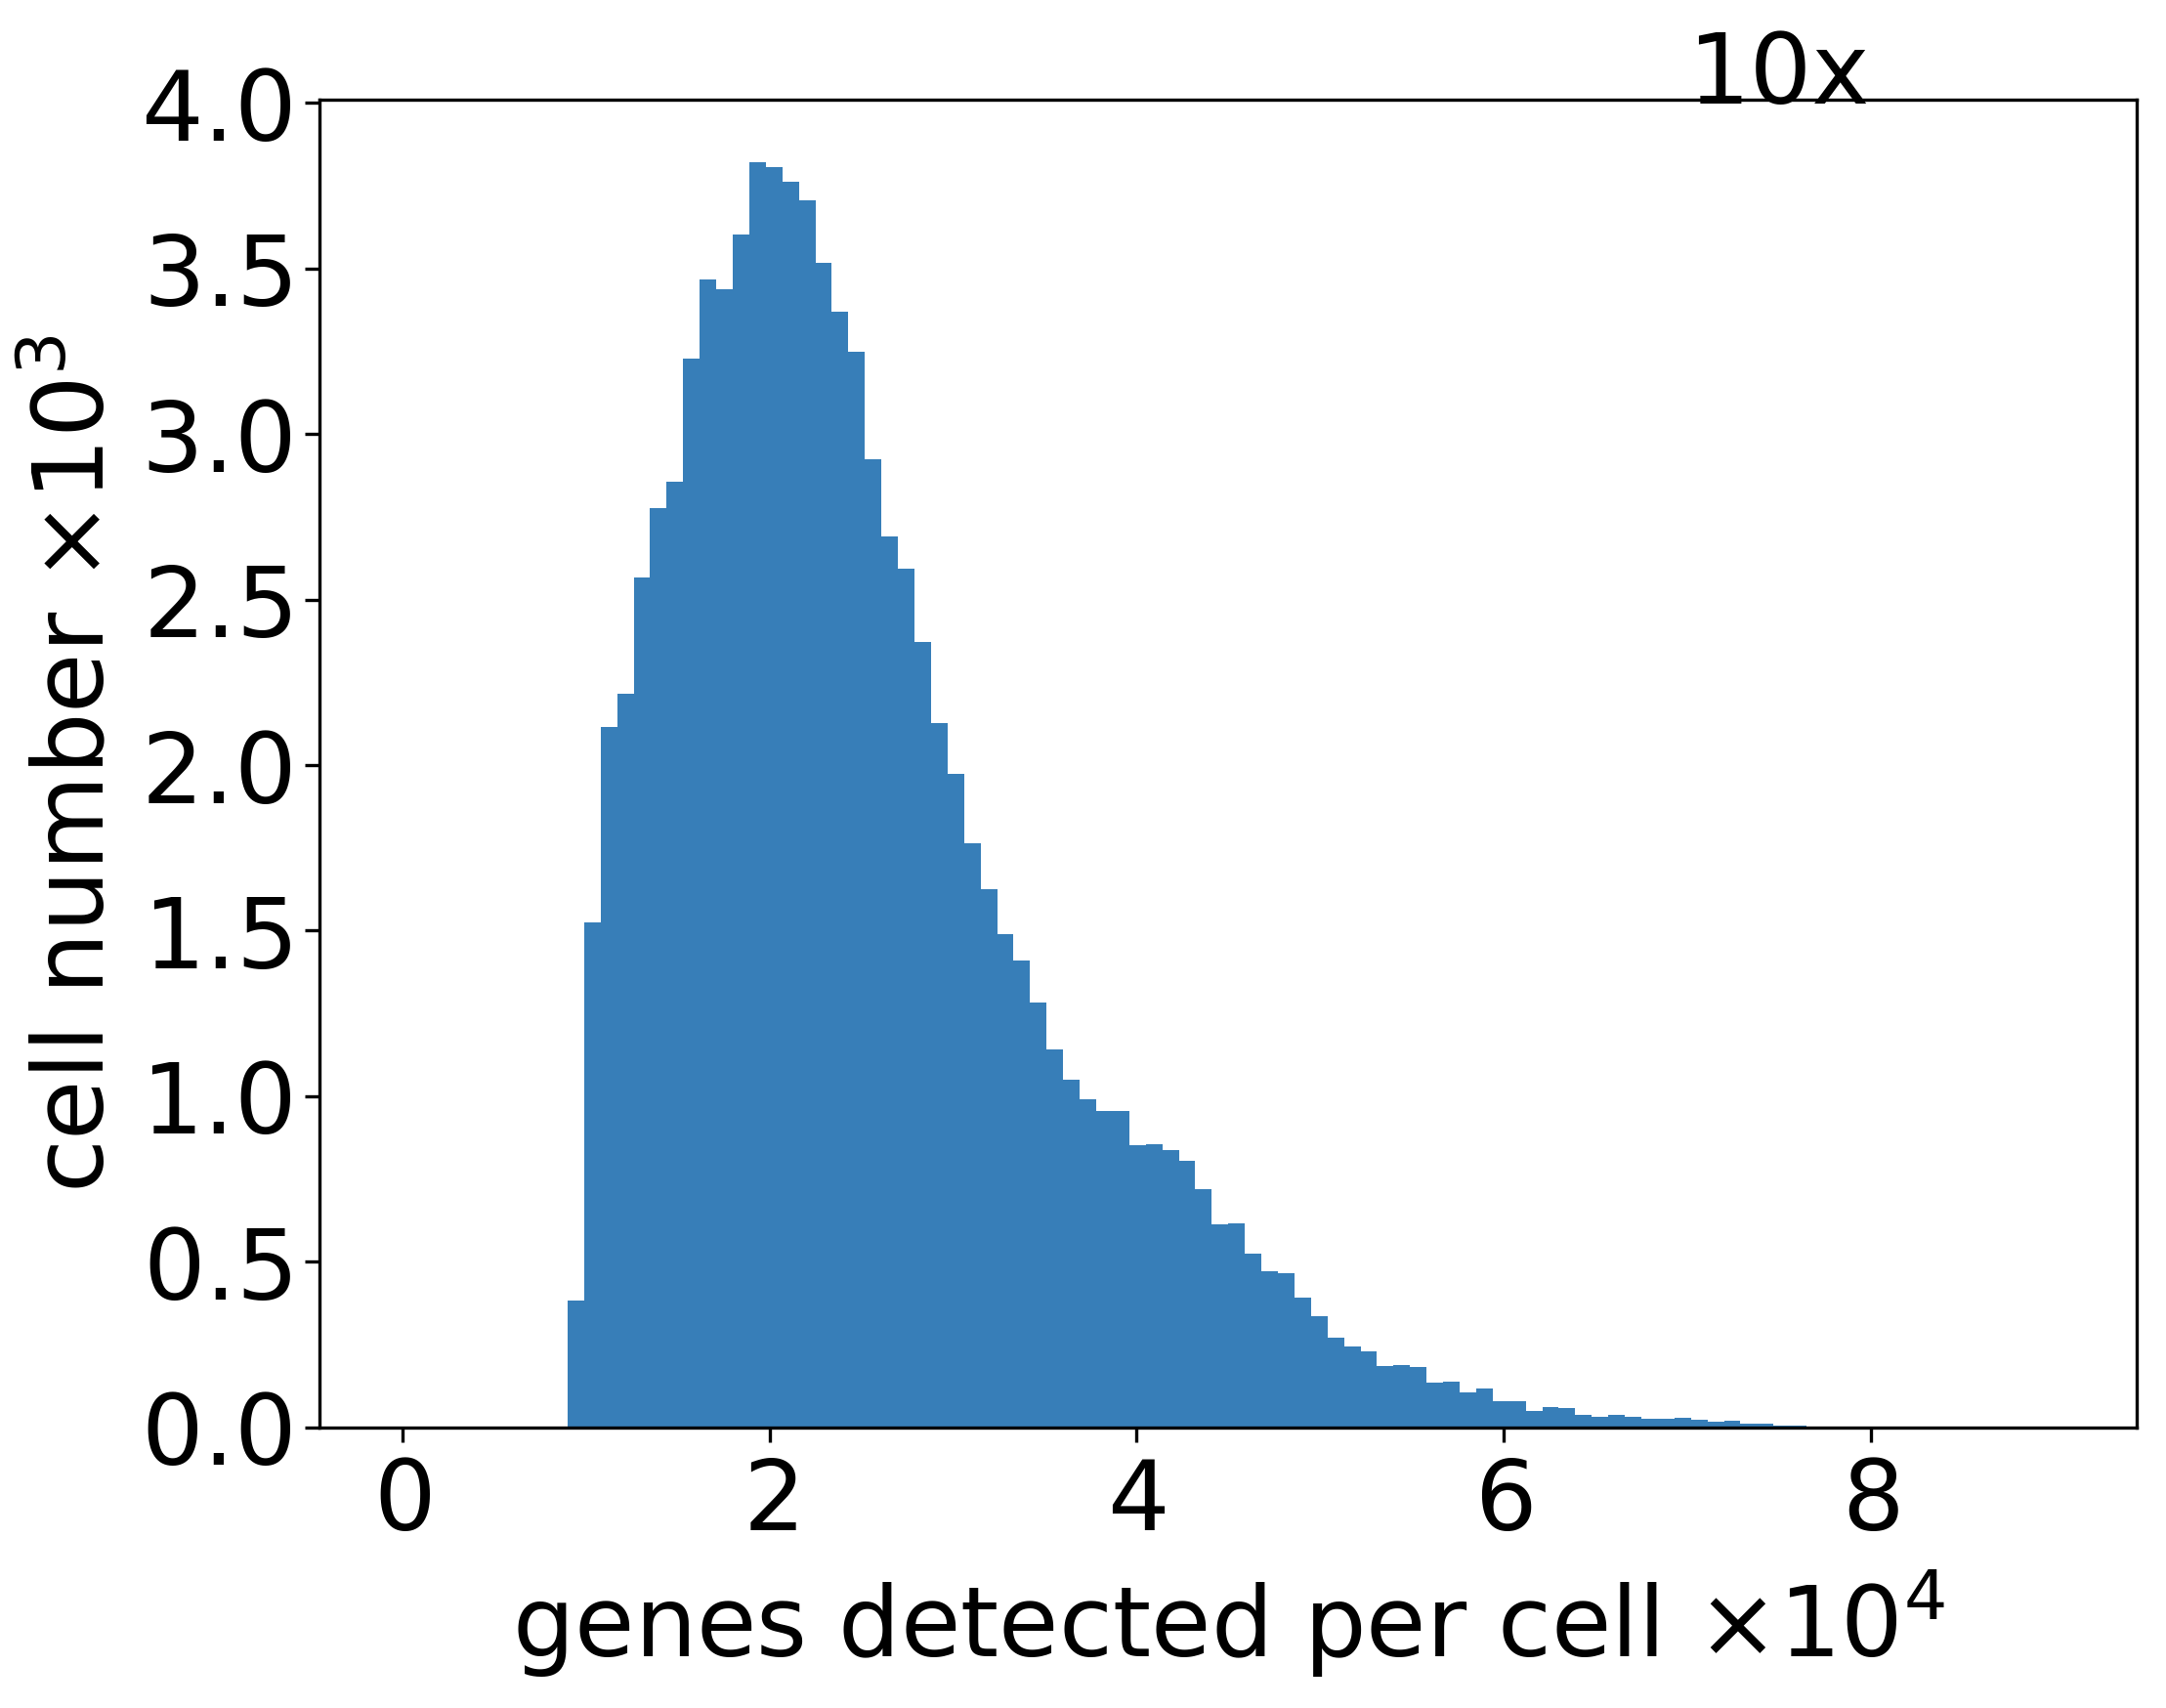

In [30]:
#x, bins, = numpy.histogram(detected_counts_df['counts'], bins=100)
#ax = pyplot.hist(x, bins, color=colors['10x'])
def genes_detected_10x(data, colors, fontsize=None, fontname='Arial', ax=None, dpi=300):
    if not ax:
        f = pyplot.figure(figsize=(8,6), dpi=300)
        ax = f.add_subplot(1,1,1)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    ax.hist(data['counts'], bins=100, color=colors['10x'], range=xlim)
    #ax = data['counts'].plot.hist(bins=100, legend=False, color=colors['10x'], xlim=xlim, ax=ax)

    for l in ax.get_yticklabels():
        l.set_fontsize(fontsize)
        l.set_fontname(fontname)
    for l in ax.get_xticklabels():
        l.set_fontsize(fontsize)
        l.set_fontname(fontname)
        #l.set_rotation(90)
    _ = ax.set_ylabel('cell number $\\times$10$^3$', fontsize=fontsize, fontname=fontname)
    #  $\geq$ 1 FPKM
    _ = ax.set_xlabel('genes detected per cell $\\times$10$^4$',fontsize=fontsize, fontname=fontname)
    _ = ax.text(7000, 4000, '10x', fontsize=fontsize, fontname=fontname)
    ax.get_xaxis().get_offset_text().set_fontsize(fontsize-.2 * fontsize)
    ax.get_yaxis().get_offset_text().set_fontsize(fontsize-.2 * fontsize)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    print('10x x', ax.get_yaxis().get_offset_text())
    print('10x y', ax.get_yaxis().get_offset_text())
    
    return ax.figure

f = genes_detected_10x(expressed_10x, colors, fontsize)
f.savefig('protein_coding_genes_detected_10x.png')
f.savefig('protein_coding_genes_detected_10x.svg')
f.savefig('protein_coding_genes_detected_10x.eps')


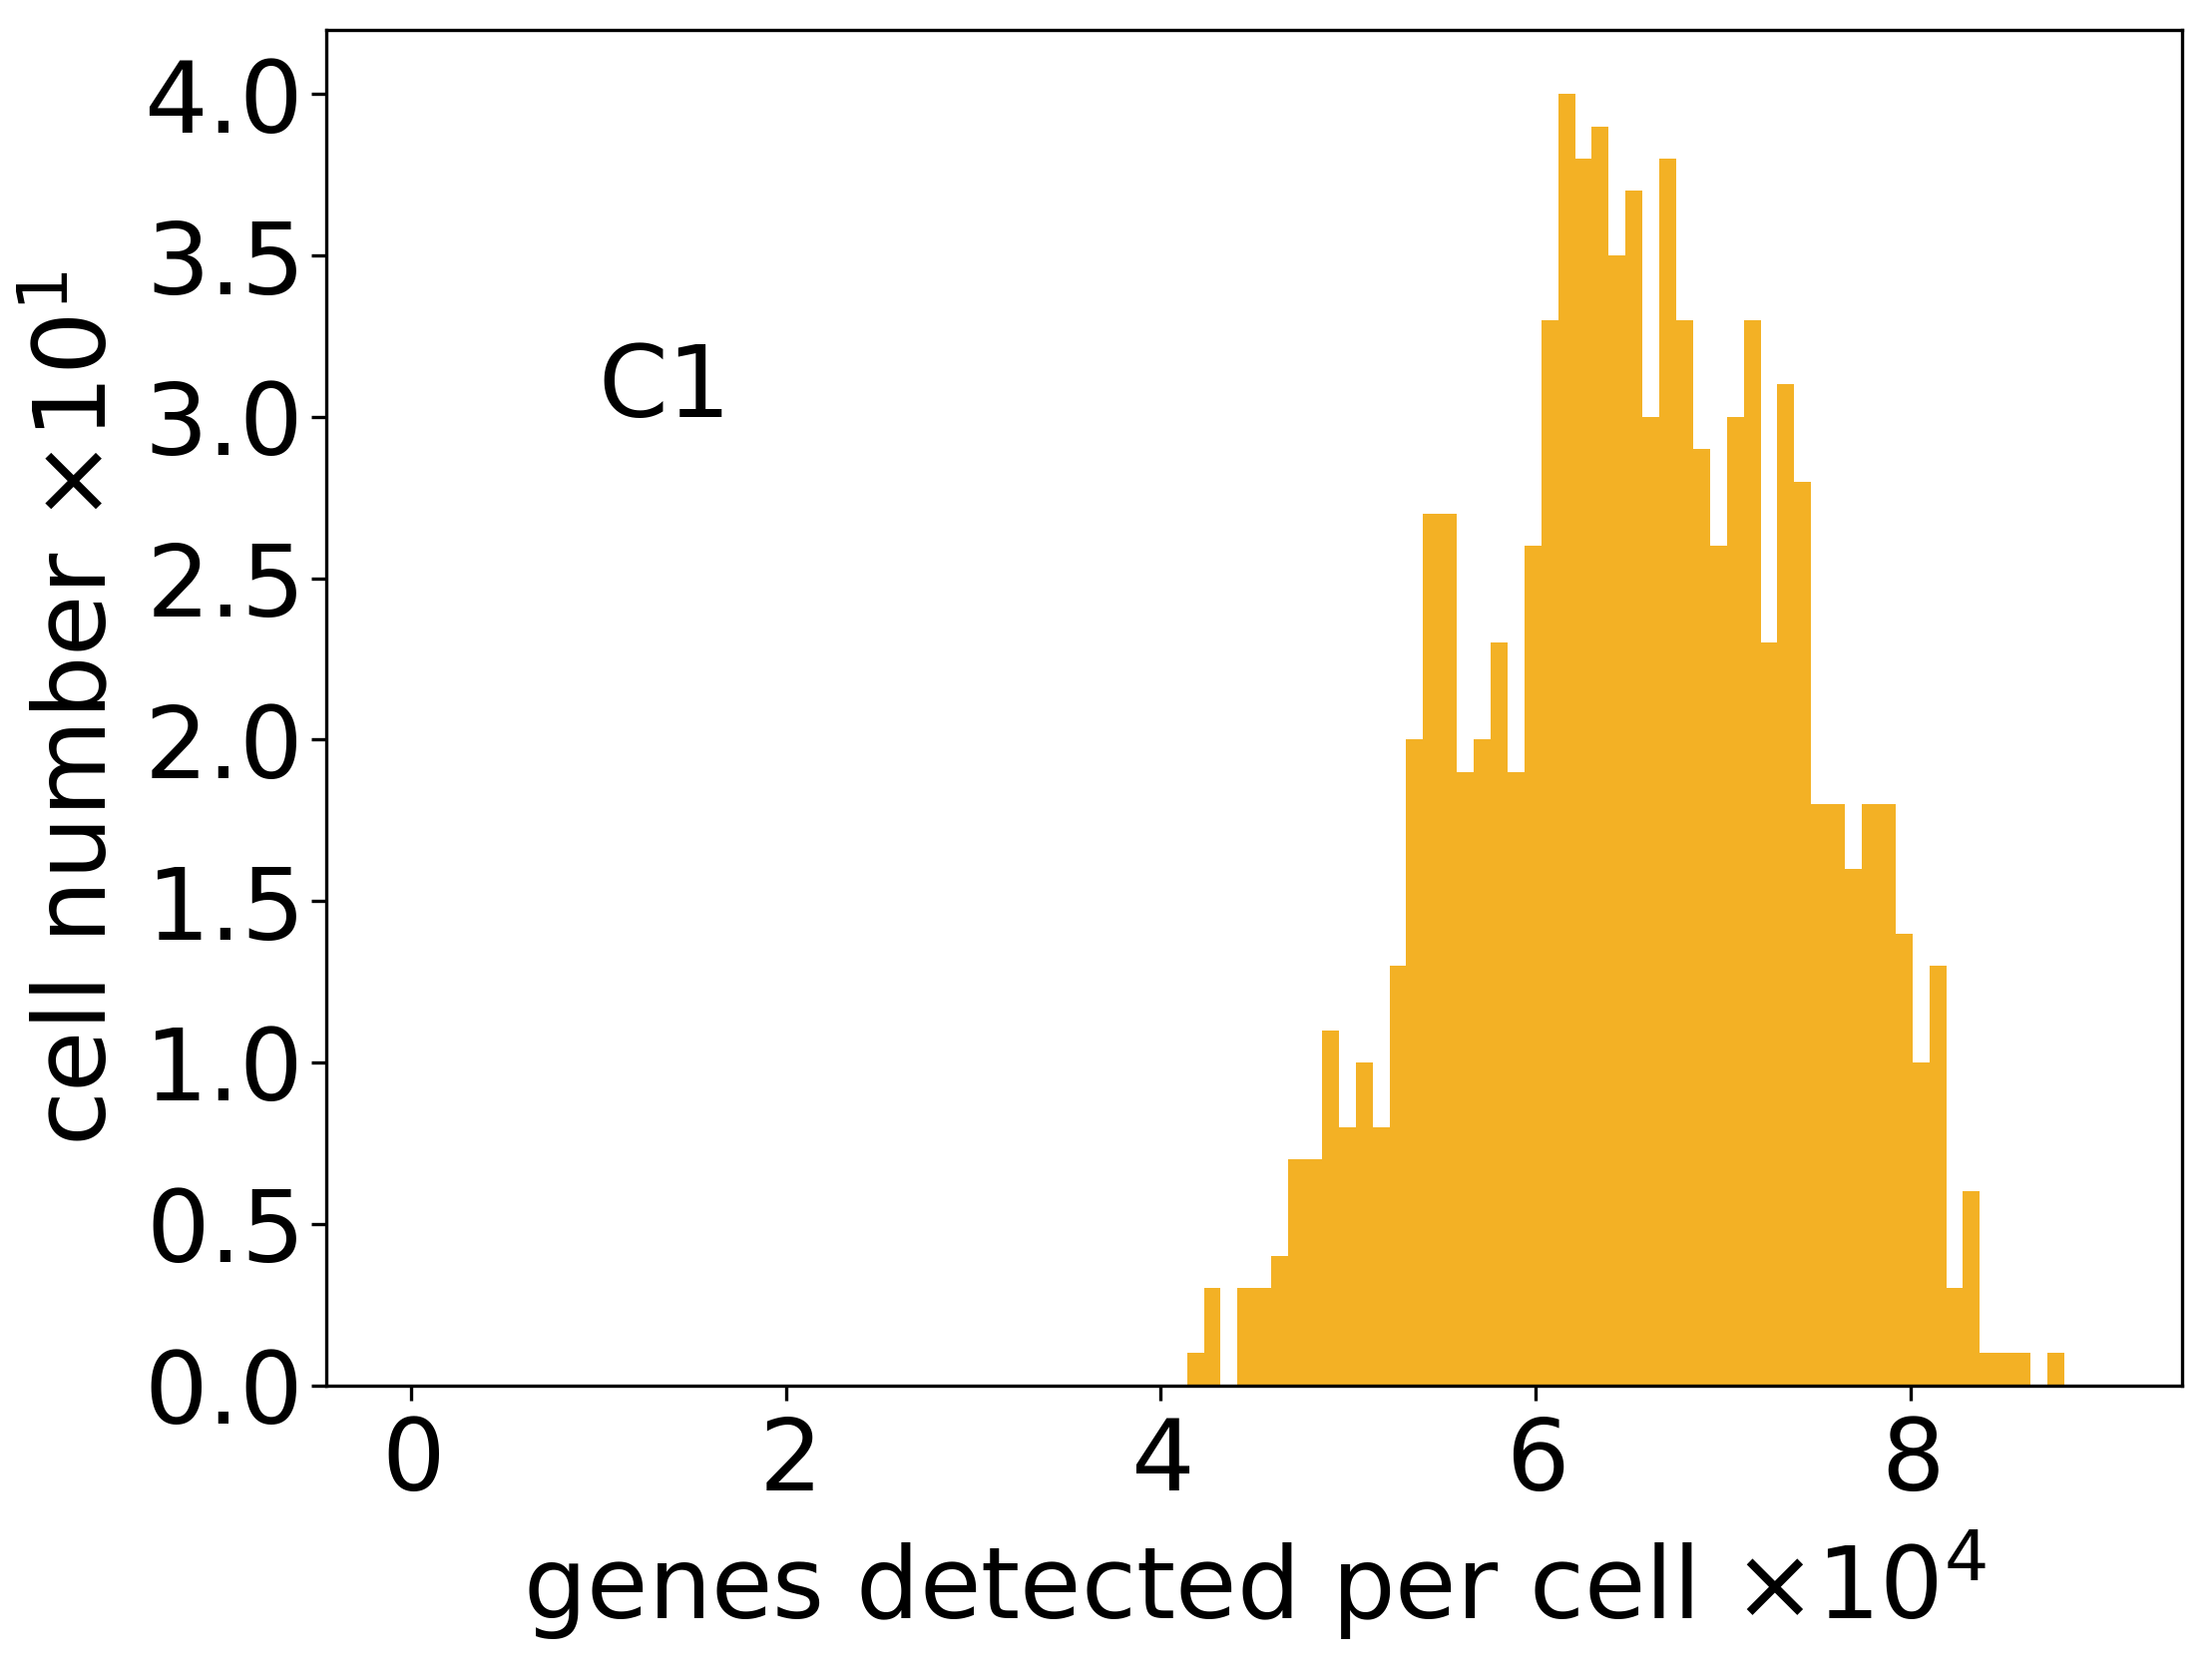

In [31]:
def genes_detected_C1(data, colors, fontsize, fontname='Arial', ax=None, dpi=300):
    if not ax:
        f = pyplot.figure(figsize=(8,6), dpi=300)
        ax = f.add_subplot(1,1,1)
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
    #ax = data.plot.hist(bins=100, color=colors['C1'], legend=False, xlim=xlim, ax=ax)
    ax.hist(data['counts'], bins=100, color=colors['C1'], range=xlim)
    
    for l in ax.get_yticklabels():
        l.set_fontsize(fontsize)
        l.set_fontname(fontname)
    for l in ax.get_xticklabels():
        l.set_fontsize(fontsize)
        l.set_fontname(fontname)
        #l.set_rotation(90)
    _ = ax.set_ylabel('cell number $\\times$10$^1$', size=fontsize)    
    #  $\geq$ 1 FPKM
    _ = ax.set_xlabel('genes detected per cell $\\times$10$^4$', size=fontsize, fontname=fontname)
    _ = ax.text(1000, 30, 'C1', fontsize=fontsize, fontname=fontname)
    ax.get_xaxis().get_offset_text().set_fontsize(fontsize-.2 * fontsize)
    ax.get_yaxis().get_offset_text().set_fontsize(fontsize-.2 * fontsize)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    return ax.figure
genes_detected_C1(expressed_c1, colors, fontsize)
f.savefig('protein_coding_genes_detected_C1.png')
f.savefig('protein_coding_genes_detected_C1.svg')
f.savefig('protein_coding_genes_detected_C1.eps')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


10x x Text(0, 0.5, '')
10x y Text(0, 0.5, '')


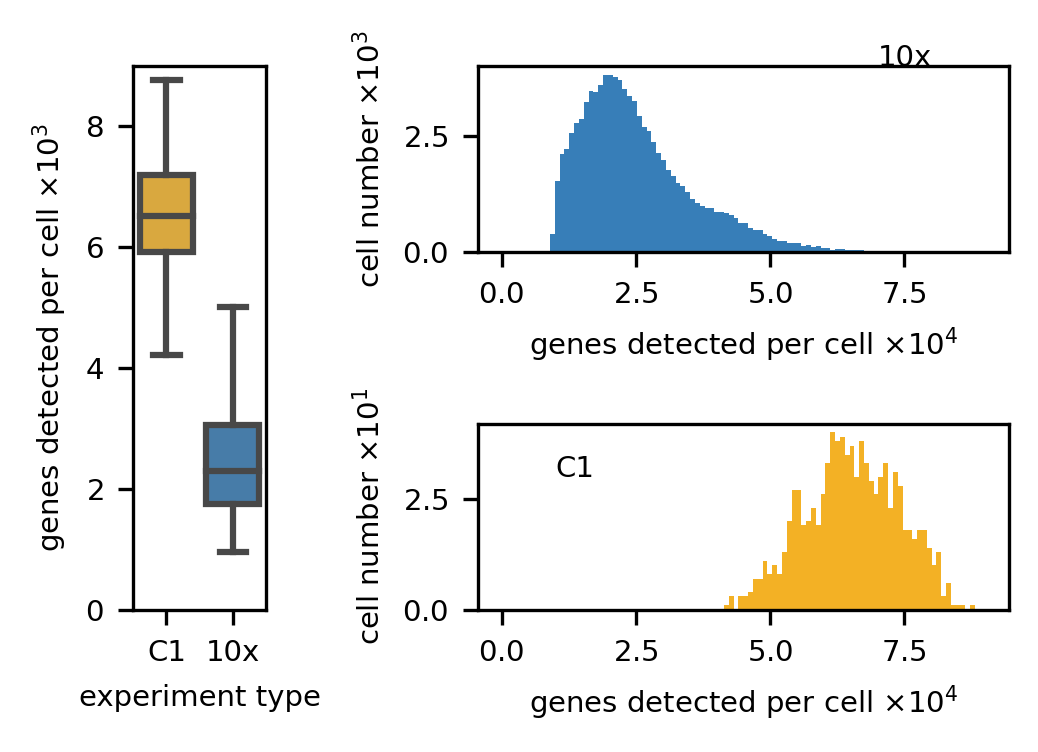

In [32]:
mm2inch = 25.4

f = pyplot.figure(figsize=(85/mm2inch, 60/mm2inch), dpi=300, constrained_layout=True)
gs = f.add_gridspec(2, 2, width_ratios=[1,4], hspace=-.5)
f_ax1 = f.add_subplot(gs[:, 0])
f_ax2 = f.add_subplot(gs[0, 1:])
f_ax3 = f.add_subplot(gs[1, 1:])

multifont = 7.0
_ = compare_genes_detected(combined, colors, multifont, ax=f_ax1)
_ = genes_detected_10x(expressed_10x, colors, multifont, ax=f_ax2)
_ = genes_detected_C1(expressed_c1, colors, multifont, ax=f_ax3)

In [33]:
f.savefig('by_platform_grid.png')
f.savefig('by_platform_grid.svg')
f.savefig('by_platform_grid.eps')

In [34]:
combined.shape

(91557, 3)

In [35]:
expressed_10x.shape

(90637, 2)

In [37]:
combined.head()

,counts,experiment type,cell_ID
0,3031,10x,NaN
1,1809,10x,NaN
2,2192,10x,NaN
3,3936,10x,NaN
4,2725,10x,NaN


In [38]:
expressed_c1.head()

,cell_ID,counts,experiment type
0,18317_G10,7822,C1
1,20040_B1,6802,C1
2,20044_A10,7138,C1
3,20042_D4,6972,C1
4,18255_E8,7306,C1


In [39]:
combined[['experiment type', 'counts']].to_csv('genes_detected_technology.csv', index=False)